Reading classics [Python Machine Learning 3rd Edition](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch15/ch15_part1.ipynb)

In [1]:
from IPython.display import display,HTML

c1,c2,f1,f2,fs1,fs2=\
'#11ff66','#6611ff','Wallpoet','Orbitron',20,10
def dhtml(string,fontcolor=c1,font=f1,fontsize=fs1):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family="""\
    +font+"""&effect=3d-float';</style>
    <h1 class='font-effect-3d-float' 
    style='font-family:"""+font+\
    """; color:"""+fontcolor+\
    """; font-size:"""+str(fontsize)+"""px;'>
    %s</h1>"""%string))

dhtml('Code Modules, Setting, & Functions')

In [2]:
!python3 -m pip install --upgrade pip \
--user --quiet --no-warn-script-location
!python3 -m pip install --upgrade tensorflow==2.3.0 \
--user --quiet --no-warn-script-location
!pip install mplcyberpunk --user --quiet

In [3]:
import warnings; warnings.filterwarnings('ignore')
import mplcyberpunk,numpy as np
import tensorflow as tf,pylab as pl
from IPython.core.magic import register_line_magic
from sklearn.metrics import \
classification_report,confusion_matrix
pl.style.use('cyberpunk')

@register_line_magic
def display_examples(pars):
    pars=pars.split()
    data,n=pars[0],int(pars[1])
    if data=='mnist': data=mnist_test
    if data=='cifar': data=cifar_test
    batch=next(iter(data.batch(n)))
    images=batch[0].numpy()
    labels=batch[1].numpy() 
    fig=pl.figure(figsize=(2*n//3,4.5))
    for i in range(n):
        ax=fig.add_subplot(3,n//3,i+1)
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(np.squeeze(images[i]),
                  cmap='bone')
        ax.text(.85,.15,'{}'.format(labels[i]), 
                fontdict={'color':c1,'fontsize':30},
                horizontalalignment='center',
                verticalalignment='center', 
                transform=ax.transAxes)
    pl.tight_layout(); pl.show()
    
@register_line_magic
def history_plot(yes):
    global history
    pl.figure(figsize=(10,10)); pl.subplot(211)
    keys=list(history.history.keys())[0:4]
    pl.plot(history.history[keys[0]],
            color=c1,label=keys[0])
    pl.plot(history.history[keys[2]],
            color=c2,label=keys[2])
    pl.xlabel('Epochs'); pl.ylabel('Loss')
    pl.legend(); pl.grid(); pl.title('Loss Function')     
    pl.subplot(212)
    pl.plot(history.history[keys[1]],
            color=c1,label=keys[1])
    pl.plot(history.history[keys[3]],
            color=c2,label=keys[3])
    pl.xlabel('Epochs'); pl.ylabel('Accuracy')    
    pl.legend(); pl.grid(); pl.title('Accuracy')
    mplcyberpunk.add_glow_effects()
    pl.tight_layout(); pl.show()
    
@register_line_magic
def display_reports(data):
    global model,model_weights,buffer_size,c2,f2,fs2
    model.load_weights(model_weights)
    if data=='mnist': data=mnist_test
    if data=='cifar': data=cifar_test
    test_results=model.evaluate(
        data.batch(buffer_size),verbose=0)
    dhtml('\ntest accuracy: {:.2f}%'\
          .format(test_results[1]*100),c2,f2,fs2)
    batch=next(iter(data.batch(buffer_size)))
    y_test=batch[1].numpy()
    py_test=np.argmax(
        model.predict(data.batch(buffer_size)),axis=-1)
    dhtml('Classification Report',c2,f2,fs2)
    print(classification_report(y_test,py_test))
    dhtml('Confusion Matrix',c2,f2,fs2)
    print(confusion_matrix(y_test,py_test))

In [4]:
dhtml('Data Processing')

In [5]:
%%writefile tfpreprocess_mnist.py
import warnings; warnings.filterwarnings('ignore')
import tensorflow as tf,numpy as np,pandas as pd
import tensorflow_datasets as tfds
from IPython.display import display,HTML
pd.set_option('precision',3)
tf.keras.backend.set_floatx('float64')
tfds.disable_progress_bar()
img_size=32
buffer_size,batch_size=10000,64

c1,c2,f1,f2,fs1,fs2=\
'#11ff66','#6611ff','Wallpoet','Orbitron',20,10

def dhtml(string,fontcolor=c1,font=f1,fontsize=fs1):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family="""\
    +font+"""&effect=3d-float';</style>
    <h1 class='font-effect-3d-float' 
    style='font-family:"""+font+\
    """; color:"""+fontcolor+\
    """; font-size:"""+str(fontsize)+"""px;'>
    %s</h1>"""%string))

def load_mnist():
    mnist=tfds.builder('mnist')
    mnist.download_and_prepare()
    ds=mnist.as_dataset(shuffle_files=False,
                        split=['train','test'])
    mnist_train,mnist_test=ds[0],ds[1]
    dhtml(mnist.info.features['image'],c2,f2,fs2)
    dhtml(mnist.info.features['label'],c2,f2,fs2)
    mnist_train=mnist_train.map(
        lambda item:(tf.image.resize(
            tf.cast(item['image'],tf.float32),
            [img_size,img_size])/255., 
                     tf.cast(item['label'],tf.int32)))
    mnist_test=mnist_test.map(
        lambda item:(tf.image.resize(
            tf.cast(item['image'],tf.float32),
            [img_size,img_size])/255., 
                     tf.cast(item['label'],tf.int32)))
    tf.random.set_seed(123)
    mnist_train=mnist_train.shuffle(
        buffer_size=buffer_size,
        reshuffle_each_iteration=False)
    mnist_valid=mnist_train.take(buffer_size).batch(batch_size)
    mnist_train=mnist_train.skip(buffer_size).batch(batch_size)
    return mnist_train,mnist_valid,mnist_test

Writing tfpreprocess_mnist.py


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


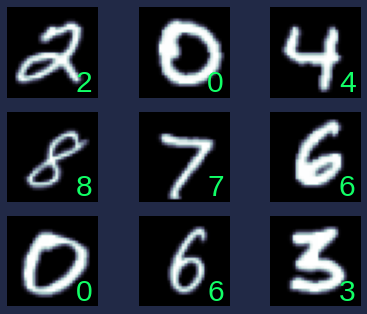

In [6]:
%run tfpreprocess_mnist.py
mnist_train,mnist_valid,mnist_test=load_mnist()
%display_examples mnist 9

In [7]:
%%writefile tfpreprocess_cifar.py
import warnings; warnings.filterwarnings('ignore')
import tensorflow as tf,numpy as np,pandas as pd
import tensorflow_datasets as tfds
from IPython.display import display,HTML
pd.set_option('precision',3)
tf.keras.backend.set_floatx('float64')
tfds.disable_progress_bar()
img_size=32
buffer_size,batch_size=10000,64

c1,c2,f1,f2,fs1,fs2=\
'#11ff66','#6611ff','Wallpoet','Orbitron',20,10

def dhtml(string,fontcolor=c1,font=f1,fontsize=fs1):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family="""\
    +font+"""&effect=3d-float';</style>
    <h1 class='font-effect-3d-float' 
    style='font-family:"""+font+\
    """; color:"""+fontcolor+\
    """; font-size:"""+str(fontsize)+"""px;'>
    %s</h1>"""%string))

def load_cifar():
    cifar=tfds.builder('cifar10')
    cifar.download_and_prepare()
    ds=cifar.as_dataset(shuffle_files=False,
                        split=['train','test'])
    cifar_train,cifar_test=ds[0],ds[1]
    dhtml(cifar.info.features['image'],c2,f2,fs2)
    dhtml(cifar.info.features['label'],c2,f2,fs2)
    cifar_train=cifar_train.map(
        lambda item:(tf.cast(item['image'],tf.float32)/255., 
                     tf.cast(item['label'],tf.int32)))
    cifar_test=cifar_test.map(
        lambda item:(tf.cast(item['image'],tf.float32)/255., 
                      tf.cast(item['label'],tf.int32)))
    tf.random.set_seed(123)
    cifar_train=cifar_train.shuffle(
        buffer_size=buffer_size,
        reshuffle_each_iteration=False)
    cifar_valid=cifar_train.take(buffer_size).batch(batch_size)
    cifar_train=cifar_train.skip(buffer_size).batch(batch_size)
    return cifar_train,cifar_valid,cifar_test   

Writing tfpreprocess_cifar.py


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete232YIP/cifar10-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete232YIP/cifar10-test.tfrecord
Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


<Figure size 432x288 with 0 Axes>

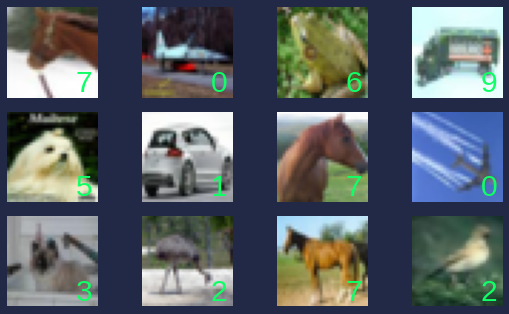

In [8]:
%run tfpreprocess_cifar.py
cifar_train,cifar_valid,cifar_test=load_cifar()
%display_examples cifar 12

In [9]:
dhtml('CNN Construction. One Channel')

In [10]:
%%writefile cnn_classify.py
import warnings; warnings.filterwarnings('ignore')
from IPython.display import display
import tensorflow as tf,numpy as np
import tensorflow.keras.layers as tkl
import tensorflow.keras.utils as tku
import tensorflow.keras.callbacks as tkc
tf.keras.backend.set_floatx('float64')

def cb(mw):
    early_stopping=tkc.EarlyStopping(
        monitor='val_loss',patience=20,verbose=2)
    checkpointer=tkc.ModelCheckpoint(
        filepath=mw,save_best_only=True,verbose=2,
        save_weights_only=True,monitor='val_accuracy',mode='max')
    lr_reduction=tkc.ReduceLROnPlateau(
        monitor='val_loss',verbose=2,patience=10,factor=.8)
    return [checkpointer,early_stopping,lr_reduction]

def main_block_cnn(channels,img_size=32,filters=32):
    model=tf.keras.Sequential()
    model.add(tkl.Input(
        (img_size,img_size,channels),name='input'))
    model.add(tkl.Conv2D(
        filters=filters,kernel_size=(7,7),
        strides=(1,1),padding='same',name='conv_1'))
    model.add(tkl.LeakyReLU(alpha=.02,name='lrelu_1'))
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=(2,2),name='pool_1'))
    model.add(tkl.Dropout(.25,name='drop_1'))
    model.add(tkl.Conv2D(
        filters=3*channels*filters,kernel_size=(7,7),
        strides=(1,1),padding='same',name='conv_2'))
    model.add(tkl.LeakyReLU(alpha=.02,name='lrelu_2'))
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=(2,2),name='pool_2'))
    model.add(tkl.Dropout(.25,name='drop_2'))
    model.add(tkl.Conv2D(
        filters=filters,kernel_size=(7,7),
        strides=(1,1),padding='same',name='conv_3'))
    model.add(tkl.LeakyReLU(alpha=.02,name='lrelu_3'))
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=(2,2),name='pool_3'))
    model.add(tkl.Dropout(.25,name='drop_3'))
    return model

def out_block_cnn(model,dense,num_classes,plot=True):
    model.add(tkl.GlobalMaxPooling2D(name='gmpool'))   
    model.add(tkl.Dense(dense,name='dense_1'))
    model.add(tkl.LeakyReLU(alpha=.02,name='lrelu_4'))
    model.add(tkl.Dropout(.5,name='drop_4'))
    model.add(tkl.Dense(num_classes,name='out',
                        activation='softmax'))
    if plot:
        display(tku.plot_model(model,show_shapes=True))
    return model

def compile_model(model):
    return model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses\
        .SparseCategoricalCrossentropy(),
        metrics=['accuracy'])

Writing cnn_classify.py


In [11]:
%run cnn_classify.py
model=main_block_cnn(1)
model.compute_output_shape(
    input_shape=(batch_size,img_size,img_size,1))

TensorShape([64, 4, 4, 32])

<Figure size 432x288 with 0 Axes>

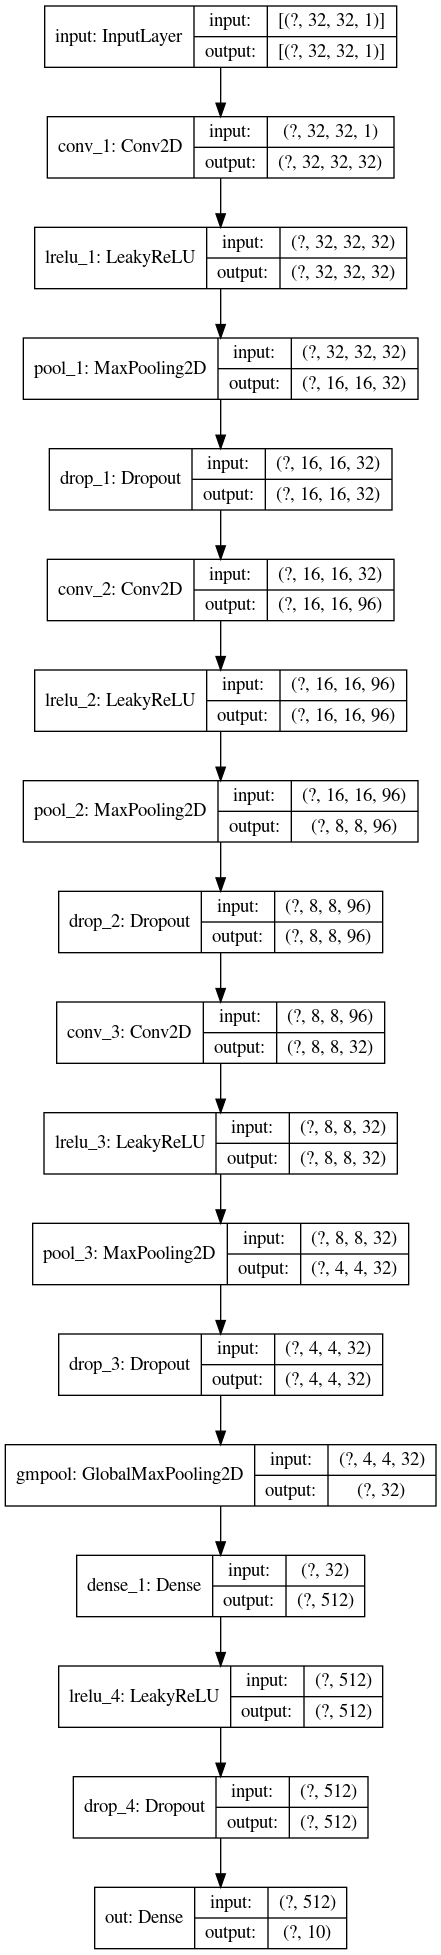

In [12]:
model=out_block_cnn(model,512,10)
compile_model(model)

In [13]:
model_weights='/checkpoints'
history=model.fit(mnist_train,epochs=50,shuffle=True, 
                  validation_data=mnist_valid,
                  callbacks=cb(model_weights))

Epoch 1/50
782/782 [==============================] - ETA: 0s - loss: 0.2948 - accuracy: 0.9019
Epoch 00001: val_accuracy improved from -inf to 0.97950, saving model to /checkpoints
782/782 [==============================] - 17s 22ms/step - loss: 0.2948 - accuracy: 0.9019 - val_loss: 0.0690 - val_accuracy: 0.9795
Epoch 2/50
779/782 [============================>.] - ETA: 0s - loss: 0.0748 - accuracy: 0.9771
Epoch 00002: val_accuracy improved from 0.97950 to 0.98390, saving model to /checkpoints
782/782 [==============================] - 15s 19ms/step - loss: 0.0747 - accuracy: 0.9771 - val_loss: 0.0524 - val_accuracy: 0.9839
Epoch 3/50
778/782 [============================>.] - ETA: 0s - loss: 0.0593 - accuracy: 0.9828
Epoch 00003: val_accuracy improved from 0.98390 to 0.98890, saving model to /checkpoints
782/782 [==============================] - 14s 18ms/step - loss: 0.0591 - accuracy: 0.9828 - val_loss: 0.0383 - val_accuracy: 0.9889
Epoch 4/50
778/782 [============================>

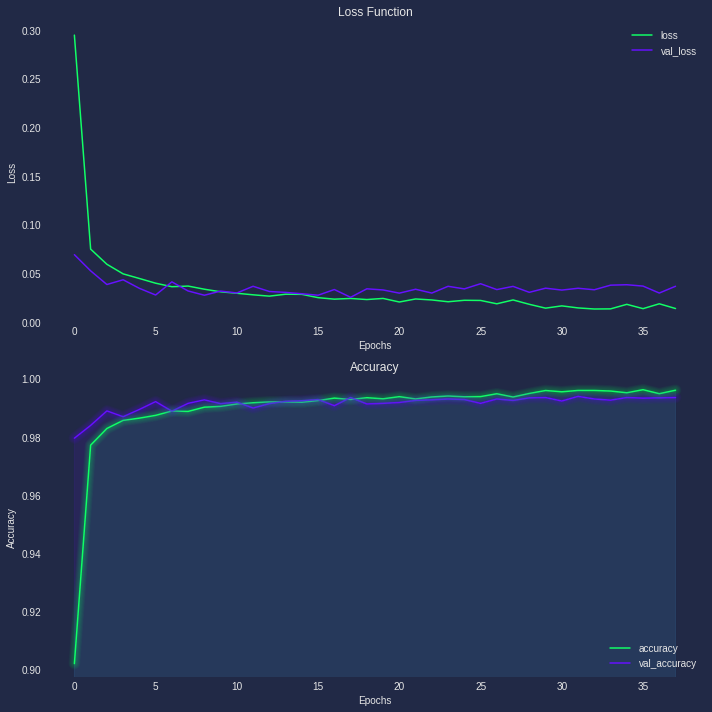

In [14]:
%history_plot yes

In [15]:
%display_reports mnist

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       0.99      1.00      1.00      1010
           4       0.99      0.99      0.99       982
           5       1.00      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       1.00      0.99      1.00      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



[[ 977    0    0    0    0    0    1    1    1    0]
 [   0 1134    1    0    0    0    0    0    0    0]
 [   1    0 1028    1    0    0    0    1    1    0]
 [   0    0    0 1008    0    1    0    0    1    0]
 [   0    0    0    0  977    0    2    0    1    2]
 [   1    0    0    4    0  885    1    0    0    1]
 [   2    2    0    0    0    1  952    0    1    0]
 [   0    3    2    0    0    0    0 1022    0    1]
 [   0    2    1    1    0    1    0    0  967    2]
 [   0    0    0    0    5    0    0    1    1 1002]]


In [16]:
dhtml('CNN Construction. Three Channels')

In [17]:
model=main_block_cnn(3)
model.compute_output_shape(
    input_shape=(batch_size,img_size,img_size,3))

TensorShape([64, 4, 4, 32])

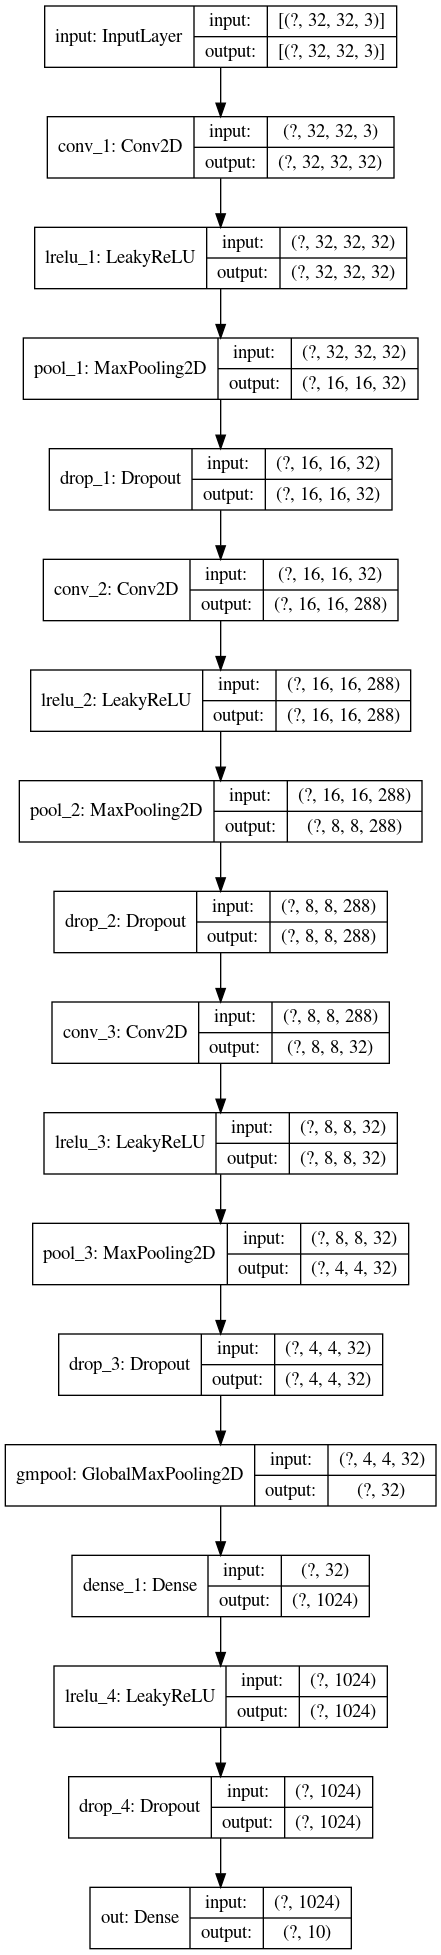

In [18]:
model=out_block_cnn(model,1024,10)
compile_model(model)

In [19]:
history=model.fit(cifar_train,epochs=70,shuffle=True, 
                  validation_data=cifar_valid,
                  callbacks=cb(model_weights))

Epoch 1/70
625/625 [==============================] - ETA: 0s - loss: 1.6894 - accuracy: 0.3706
Epoch 00001: val_accuracy improved from -inf to 0.51220, saving model to /checkpoints
625/625 [==============================] - 27s 43ms/step - loss: 1.6894 - accuracy: 0.3706 - val_loss: 1.3920 - val_accuracy: 0.5122
Epoch 2/70
625/625 [==============================] - ETA: 0s - loss: 1.3337 - accuracy: 0.5123
Epoch 00002: val_accuracy improved from 0.51220 to 0.59260, saving model to /checkpoints
625/625 [==============================] - 24s 38ms/step - loss: 1.3337 - accuracy: 0.5123 - val_loss: 1.2050 - val_accuracy: 0.5926
Epoch 3/70
625/625 [==============================] - ETA: 0s - loss: 1.1899 - accuracy: 0.5744
Epoch 00003: val_accuracy improved from 0.59260 to 0.62130, saving model to /checkpoints
625/625 [==============================] - 25s 40ms/step - loss: 1.1899 - accuracy: 0.5744 - val_loss: 1.0859 - val_accuracy: 0.6213
Epoch 4/70
625/625 [=============================

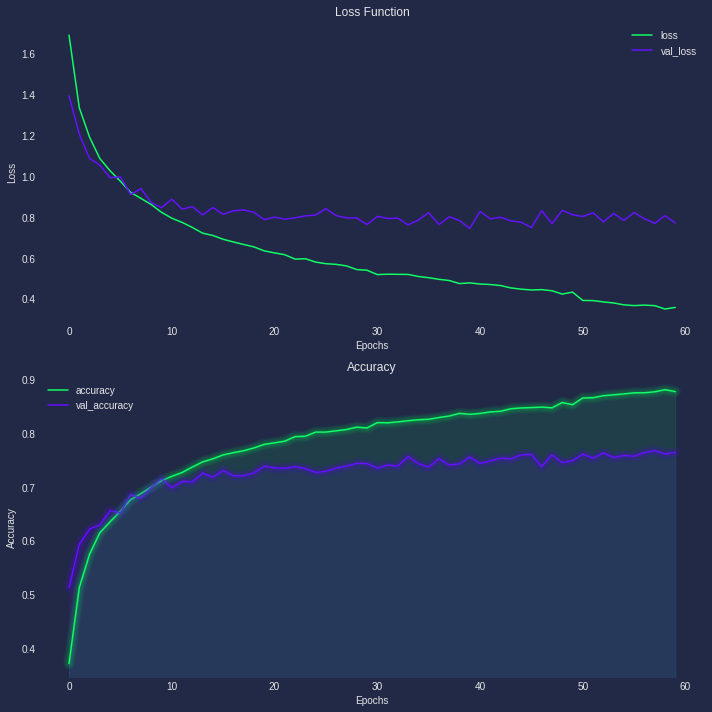

In [20]:
%history_plot yes

In [21]:
%display_reports cifar

              precision    recall  f1-score   support

           0       0.80      0.72      0.76      1000
           1       0.93      0.83      0.88      1000
           2       0.64      0.68      0.66      1000
           3       0.57      0.58      0.58      1000
           4       0.68      0.77      0.72      1000
           5       0.66      0.67      0.67      1000
           6       0.78      0.85      0.81      1000
           7       0.92      0.71      0.80      1000
           8       0.84      0.87      0.85      1000
           9       0.80      0.87      0.84      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



[[723  10  83  28  29   2  10   3  81  31]
 [ 13 830   8  13   1   5   9   0  20 101]
 [ 40   2 684  55  77  52  63  11   7   9]
 [ 18   2  65 584  64 154  69   9  14  21]
 [ 14   1  63  53 766  34  36  21   8   4]
 [  7   1  62 149  49 671  33  15   6   7]
 [  8   3  31  45  31  23 847   1   5   6]
 [ 14   1  39  59  99  55   9 709   2  13]
 [ 48  14  16  18   4   6   6   0 868  20]
 [ 20  33  10  17   8   8   7   5  21 871]]
